In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from functools import partial
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import PCA

from typing import List

## load & split

In [2]:
purchases = pd.read_csv('retail_train.csv')
purchases.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [3]:
# train/test split
test_size_weeks = 3

train = purchases[purchases['week_no'] < purchases['week_no'].max() - test_size_weeks].copy()
test = purchases[purchases['week_no'] >= purchases['week_no'].max() - test_size_weeks].copy()

In [4]:
# products = pd.read_csv('product.csv')
# products.head(3)

In [42]:
# prepare result DataFrame
result = test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Used functions

In [6]:
# Топ популярных товаров
def popularity_measure(source, fields: List[str], k=5000, beta: List[float] = None, add_target=None, scaler=None):
    """ Расчет оценки важности товара в покупке и отбор топ K наиболее популярных товаров
    :param source - исходные данные
    :param fields - признаки, по которым измеряется мера важности товара
    :param k - количество товаров, отбираемых в топ
    :param beta - множители значимости для каждого признака в оценке
    :param add_target - название финального признака. Признак не добавляется, если target = None
    :param scaler - класс масштабирования данных
    """
    b = [1.] * len(fields) if beta is None else np.array(beta)
    assert len(fields) == len(b), '`fields` and `beta` dimensions must equal'
    assert issubclass(StandardScaler, TransformerMixin) or scaler is None, 'scaler must be a subclass of TransformerMixin'
    _df = source[['item_id']].copy()
    prepared = scaler().fit_transform(source[fields]) * b if scaler else source[fields] * b
    values = np.linalg.norm(prepared, ord=2, axis=1)
    _df['popularity'] = values
    if add_target:
        source.loc[:, add_target] = values
    popularity = _df.groupby('item_id')['popularity'].sum()
    return popularity.sort_values(ascending=False).head(k).index.tolist()

In [7]:
# предсказатель-интерпретатор
def recommender(user_id, mdl, params):
    uid = userid_to_id.get(user_id, None)
    if uid is None:
        return list()
    rec_score = mdl.recommend(userid_to_id[user_id], **params)
    return [id_to_itemid[rec[0]] for rec in rec_score]


In [8]:
# метрики
def precision_at_k(recommended_list, bought_list, k=5):
    flags = np.isin(bought_list, recommended_list[:k])
    return flags.sum() / k

def ap_k(recommended_list, bought_list, k=5):
    flags = np.isin(recommended_list, bought_list)
    if sum(flags) == 0:
        return 0

    func = partial(precision_at_k, recommended_list, bought_list)
    rel_items = np.arange(1, k + 1)[flags[:k]]
    return np.sum(list(map(func, rel_items))) / flags.sum()

In [9]:
# сериализация расчета метрики
def calc_metric(metric_func, source: pd.DataFrame):
    """ Подсчет метрики
    :param metric_func - функция измерения метрики. Первый аргумент - рекомендации, второй - актуальные значения
    :param source - данные для подсчета метрики
    """
    def metric_wrapper(pred, act):
        return metric_func(pred, act) if len(pred) != 0 else 0

    metric = pd.DataFrame()
    for col in source.columns:
        if col == 'user_id':
            metric[col] = source[col]
        elif col == 'actual':
            continue
        else:
            metric[col] = source[[col, 'actual']].apply(lambda row: metric_wrapper(*row.values), axis=1)
    return metric

In [10]:
def plot_weight_curve(data: pd.Series, p1=False):
    """ Построение графиков весов """
    _val = data.sort_values(ascending=False).values
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(f'Weights curve for {data.name}')
    ax[0].set_title('clean')
    ax[0].plot(_val)
    ax[1].set_title('log-scaled')
    ax[1].plot(np.log1p(_val) if p1 else np.log(_val))
    plt.show()

## Мысли вслух

## Baseline

In [11]:
# %%time
# # стандартный топ5000 по кол-ву проданных единиц
# top5k = popularity_measure(train, ['quantity'], k=5000, add_target='popularity')
# top5k[:7]

In [12]:
%%time
# берем топ5000 по оценке популярности товара
top5k = popularity_measure(train, ['quantity', 'sales_value'], beta=[1., 1.], k=5000, add_target='popularity', scaler=StandardScaler)
top5k[:7]

CPU times: user 532 ms, sys: 131 ms, total: 663 ms
Wall time: 773 ms


[6534178, 6533889, 1082185, 6534166, 6533765, 995242, 981760]

In [13]:
# обработка товаров не из топа
top_train = train.copy()
top_train.loc[~top_train['item_id'].isin(top5k), 'item_id'] = -1     # товары не из топ5000 превращаем в один товар
top_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,popularity
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,0.415439
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.549036
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.509067
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,0.457485
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,0.389835


In [14]:
# подготовка обучающих данных: составление таблицы user-item на основе популярности товара для пользователя
user_item_matrix = pd.pivot_table(top_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='popularity',
                                  aggfunc='sum',
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float)

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [15]:
user_item_matrix.head(3)

item_id,-1,201704,259120,397896,420647,480014,731106,818980,819063,819255,...,15927403,15927661,15971546,15972074,15972298,16053266,16100266,16769635,16809471,17242362
user_id,,,,,,,,,,,,,,,,,,,,,
1,223.148156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,89.109578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64.136018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# remap dictionaries
id_to_itemid = dict(enumerate(user_item_matrix.columns.values))
id_to_userid = dict(enumerate(user_item_matrix.index.values))

itemid_to_id = {v: k for k, v in id_to_itemid.items()}
userid_to_id = {v: k for k, v in id_to_userid.items()}

In [43]:
# обучение модели
model = AlternatingLeastSquares(factors=44,
                                regularization=0.001,
                                iterations=15,
                                calculate_training_loss=True,
                                use_gpu=False,
                                random_state=23)        # don't forget to fix RS!!!

model.fit(sparse_user_item.T, show_progress=True)
# Зачем в оригинальном ноутбуке в предыдущем шаге делаем sparse_user_item, если его нигде не используем?

  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
recommender_params = {
    'user_items': sparse_user_item,
    'N': 5, # кол-во рекомендаций
    'filter_already_liked_items': False,
    'filter_items': [itemid_to_id[-1]],
    'recalculate_user': True
}

In [44]:
%%time
result['als_baseline'] = result['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))
result.head(3)

CPU times: user 54.7 s, sys: 30.8 s, total: 1min 25s
Wall time: 55 s


,user_id,actual,als_baseline
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[995242, 1082185, 1005186, 5978656, 6534178]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5569230, 6534178, 1133018, 1082185, 1106523]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[866211, 1127831, 878996, 834484, 854852]"


In [20]:
pr_at_k = calc_metric(partial(precision_at_k, k=5), result)
ap_at_k = calc_metric(lambda pred, act: ap_k(pred, act, k=min(5, len(pred))), result)

In [21]:
summary = pd.DataFrame([pr_at_k.mean(), ap_at_k.mean()], index=['precision@k', 'map@k'])
summary.drop(columns='user_id')

,als_baseline
precision@k,0.207738
map@k,0.346116


## Взвешивание

Взвешивание применяется на обучающие данные *до обучения* модели. Таким образом, можно рассматривать его как часть этапа feature engineerin'а.
А собственно, вопрос подхода к обработке обучающих данных - это вопрос творческий.
В данной задаче ключевых моментов можно выделить три:
1) способ отбора топа товаров
2) оценка весов товаров
3) оценка весов покупателей

Взвешивать можно и пользователей, и товары:
- При взвешивании пользователей строки умножаются на вес пользователя
- При взвешивании товаров столбцы умножаются на вес товара

### оценка весов товаров

#### количество чеков, в которых есть товар

In [22]:
item_basket_count = purchases.groupby('item_id')['basket_id'].count().rename('item_basket_count')
item_basket_count[item_basket_count.index.isin(top5k)].sort_values(ascending=False).head(3)

item_id
1082185    27362
6534178    18364
1029743    13455
Name: item_basket_count, dtype: int64

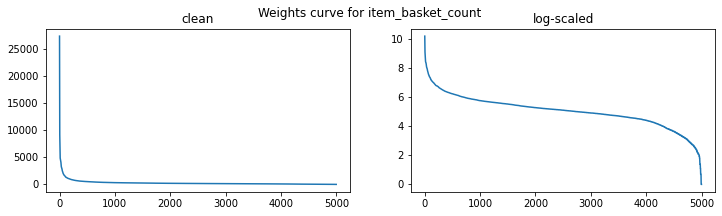

In [23]:
plot_weight_curve(item_basket_count[item_basket_count.index.isin(top5k)])

#### количество дней, когда товар был куплен

In [24]:
sell_days = purchases.groupby('item_id')['day'].nunique().rename('sell_days')
sell_days[sell_days.index.isin(top5k)].sort_values(ascending=False).head(3)

item_id
1082185    660
1029743    660
1106523    657
Name: sell_days, dtype: int64

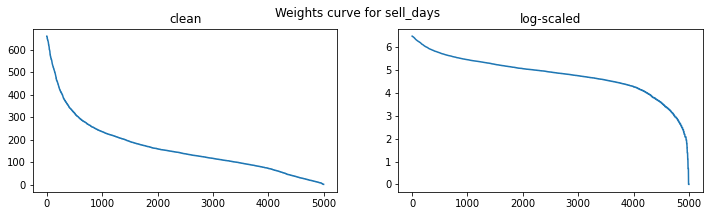

In [25]:
plot_weight_curve(sell_days[sell_days.index.isin(top5k)])

Заметим, что товар 1029743 по кол-ву проданных единиц можно счесть крайне непопулярным. Однако по встречаемости в чеках он на 3-ем месте, а по дневной продаваемости так вообще на 1ом. А самый популярный по кол-ву товар (6534178) покупали только 643 дня из 663 (15ое место).

TODO: визуализировать эти данные, определить необходимость логарифмирования для сглаживания весов

### оценка весов покупателей

* кол-во чеков на юзера (больше чеков => чаще покупает => больше вес)
* кол-во дней, когда юзер совершал покупки
* средняя сумма чека для каждого юзера (чем больше сумма, тем весомее его выбор - звучит не совсем логично, но попробовать можно)

#### количество чеков каждого покупателя

In [26]:
# кол-во чеков на юзера
user_basket_count = purchases.groupby('user_id')['basket_id'].nunique().rename('user_basket_count')
user_basket_count.sort_values(ascending=False).head()

user_id
1510    1211
2337    1192
900     1122
1795    1059
2459     964
Name: user_basket_count, dtype: int64

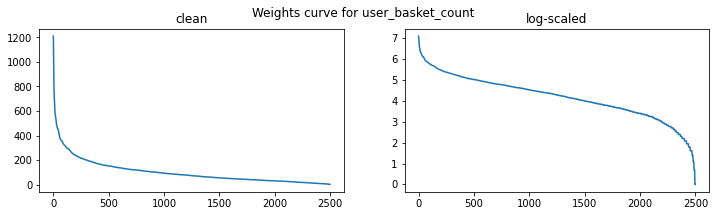

In [27]:
plot_weight_curve(user_basket_count)

#### количество дней, когда покупатель совершал покупки

In [28]:
buy_days = purchases.groupby('user_id')['day'].nunique().rename('buy_days')
buy_days.sort_values(ascending=False).head()

user_id
900     477
1510    467
1795    461
2459    443
1228    432
Name: buy_days, dtype: int64

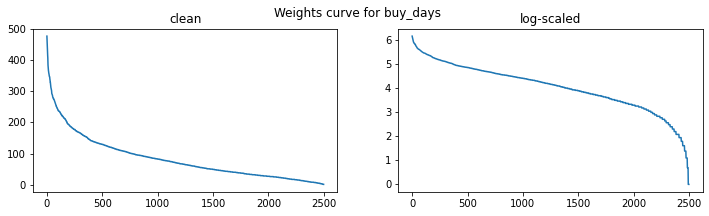

In [29]:
plot_weight_curve(buy_days)

#### средняя сумма чека каждого покупателя

In [30]:
# mbv = mean basket value
feat = purchases.groupby(['user_id', 'basket_id'])['sales_value'].sum()
mbv_per_user = feat.reset_index().groupby('user_id')['sales_value'].mean().rename('mbv_per_user')
mbv_per_user.sort_values(ascending=False).head()
# то же самое, но по-другому
# purchases.groupby('user_id')['sales_value'].sum() / purchases.groupby('user_id')['basket_id'].nunique()

user_id
2042    165.678929
1899    165.159846
973     159.481139
1900    151.074510
1574    129.143929
Name: mbv_per_user, dtype: float64

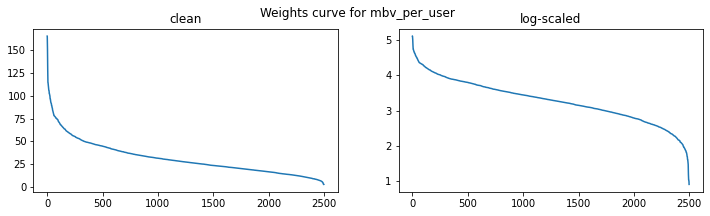

In [31]:
plot_weight_curve(mbv_per_user)

In [54]:
%%time
weights = [('i', 'item basket', item_basket_count),
           ('i', 'item basket log', np.log(item_basket_count)),
           ('i', 'sell days', sell_days),
           ('i', 'sell days log', np.log(sell_days)),
           ('u', 'user basket', user_basket_count),
           ('u', 'user basket log', np.log(user_basket_count)),
           ('u', 'buy days', buy_days),
           ('u', 'buy days log', np.log(buy_days)),
           ('u', 'mbv per user', mbv_per_user),
           ('u', 'mbv per user log', np.log(mbv_per_user)),
           ]
# metrics = pd.DataFrame(index=['precision@k', 'map@k'])
res = result.copy()

for mode, title, w in weights:
    if mode == 'u':
        matrix = csr_matrix((user_item_matrix.T * w).T).tocsr()
    else:
        weight = w[w.index.isin(top5k)]
        weight[-1] = 1
        matrix = csr_matrix(user_item_matrix * weight).tocsr()

    model = AlternatingLeastSquares(factors=44,
                                    regularization=0.001,
                                    iterations=15,
                                    calculate_training_loss=True,
                                    use_gpu=False,
                                    random_state=23)        # don't forget to fix RS!!!

    model.fit(matrix.T, show_progress=False)
    res[f'{title} weighted'] = res['user_id'].apply(partial(recommender, mdl=model, params=recommender_params))

pr_at_k = calc_metric(partial(precision_at_k, k=5), res)
ap_at_k = calc_metric(lambda pred, act: ap_k(pred, act, k=min(5, len(pred))), res)
metrics = pd.DataFrame([pr_at_k.mean(), ap_at_k.mean()], index=['precision@k', 'map@k'])
metrics.drop(columns='user_id', inplace=True)
metrics.to_csv('weighted_metrics.csv')

In [55]:
metrics

,als_baseline,item basket weighted,item basket log weighted,sell days weighted,sell days log weighted,user basket weighted,user basket log weighted,buy days weighted,buy days log weighted,mbv per user weighted,mbv per user log weighted
precision@k,0.207738,0.130362,0.217532,0.198727,0.216063,0.211166,0.206758,0.21430,0.205779,0.211655,0.208423
map@k,0.346116,0.258259,0.415540,0.408316,0.411850,0.404999,0.345018,0.41085,0.344120,0.355911,0.343728
